# imports

In [2]:
mount_dir = '/content/drive'

from google.colab import drive
drive.mount(mount_dir)

# install the package
# !pip uninstall -q tensorflow # just cuz it sucks
# %pip install -q sign-language-translator
# !pip install -q -e "/content/drive/Othercomputers/mac19/personal_repos/slt/sign-language-translator"
# remember to restart runtime after install
%cd "/content/drive/Othercomputers/mac19/personal_repos/slt/notebooks/model_training"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Othercomputers/mac19/personal_repos/slt/notebooks/model_training


In [1]:
import os
import json
import random
import re
from collections import Counter
from importlib import reload
from glob import glob
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

import sign_language_translator as slt
from sign_language_translator.models import utils
from sign_language_translator.models.language_models import (
    BeamSampling,
    transformer_language_model,
)

reload(transformer_language_model), reload(utils)
from sign_language_translator.text.utils import make_ngrams

ur = slt.languages.text.Urdu() # first import is slow because resources are downloaded

sup_words = (
    (
        {w.upper() if len(w)==1 else w for w in ur.vocab.supported_words}
        |{"دو(2)", 'ایک سو(100)'}
        |set(ur.vocab.person_names)
        |set(ur.vocab.words_to_numbers)
        |set(ur.SYMBOLS)
        |{'<', ">"}
    )
    - {'<nospeech>', '<silence>', '<|nospeech|>', '<|silence|>'}
    # - set(ur.vocab.ambiguous_to_unambiguous)
)
batch_size = 1024 * 2
vocab_size = int("101000000000",2)
window_size = 64 #int("110000",2)
embedding_size = 768
padding_token = "__pad__"
unknown_token = "__unknown__"
sos_token = "<"
len(sup_words), vocab_size, window_size, device, batch_size

(2493, 2560, 64, 'cpu', 2048)

## make `token_to_id`

In [2]:
with open("data/ur-lm-dataset-token-counts.json") as f:
    counts = json.load(f)

tokens = sorted(
    sup_words,
    key=lambda word: counts.get(word, 0),
    reverse=True,
)
print({w:c for w,c in counts.items() if w not in tokens})

with open("token_to_id.json", 'w') as f:
    json.dump({token:i for i, token in enumerate(tokens)},f, indent=4, ensure_ascii=False)

{'\n': 20574920, 'تحریک(نام)': 1}


# Dataset

In [2]:
with open("./models/token_to_id.json", 'r') as f:
    token_to_id = json.load(f)

##### `process data`

In [ ]:
tokenizer = lambda line: [
    t
    for tok in ur.tokenize(line)
    for t in (
        list(tok)
        if ur.get_tags(tok)==[slt.text.Tags.ACRONYM]
        else re.findall(
            r"("
            + r"|".join(sorted(ur.vocab.numeric_keys, key=len, reverse=True))
            + r"|[^\D0۰]|\.|[^0۰])",
            tok,
        ) if tok.replace(".", "").isnumeric()
        else [tok]
    )
]
tokens_to_ids = lambda seq: [token_to_id.get(t, token_to_id[unknown_token]) for t in seq]

text_to_token_ids = lambda text: tokens_to_ids(tokenizer(text))

In [ ]:
largest = max(token_to_id.values())
largest, torch.Tensor([largest]).type(torch.int16)

(2494, tensor([2494], dtype=torch.int16))

In [ ]:
reload(transformer_language_model)

data = transformer_language_model.LM_Dataset.prepare(
    "data/ur-lm-dataset.txt",
    text_to_token_ids,
    padding_token_id=token_to_id[padding_token],
    sequence_length=window_size,
    dtype=torch.int16,
)
data.shape

  0%|          | 0/20574921 [00:00<?, ?it/s]

##### `load data`

In [ ]:
# torch.save(data.type(torch.int16), f"data/ur-lm-dataset-w{window_size}.pt")
data = torch.load(f"data/ur-lm-dataset-w{window_size}.pt").type(torch.long)
data.shape, data.get_device()

(torch.Size([23950816, 17]), -1)

In [ ]:
# separate by length
sequence_lengths = (data != token_to_id[padding_token]).sum(axis=1)
# print(set(sequence_lengths.tolist()))
for seq_len in tqdm(set(sequence_lengths.tolist())):
    torch.save(data[sequence_lengths == seq_len, :seq_len].type(torch.int16), f"data/buckets/ur-lm-dataset-w{seq_len}.pt")

{2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}


In [ ]:
# os.makedirs("data/no-space-buckets")
for seq_len, buck in tqdm(buckets.items()):
    if seq_len > 1:
        torch.save(torch.stack(buck).type(torch.int16), f"data/no-space-buckets/ur-lm-dataset-w{seq_len}.pt")

In [3]:
data_batches = [
    chunk[i:i+batch_size]
    # for path in glob("data/buckets/ur-lm-dataset-w*.pt")
    for path in glob("data/no-space-buckets/ur-lm-dataset-w*.pt")
    for chnk in [torch.load(path).type(torch.long)]
    for chunk in [chnk[torch.randperm(len(chnk))]]
    for i in range(0,len(chunk), batch_size)
]
np.random.shuffle(data_batches)
len(data_batches)

11701

In [4]:
data = data_batches

In [5]:
train_fraction = 0.9
n_train = round(len(data) * train_fraction)
n_val = len(data) - n_train

train_dataset = transformer_language_model.train.LM_Dataset(data[:n_train])
val_dataset = transformer_language_model.train.LM_Dataset(data[n_train:])

train_batches = DataLoader(train_dataset, batch_size=None, shuffle=True)
val_batches = DataLoader(val_dataset, batch_size=None, shuffle=True)

len(train_batches), len(val_batches), next(iter(train_batches))[0].shape

(10531, 1170, torch.Size([2048, 6]))

# model

In [6]:
reload(transformer_language_model)
reload(transformer_language_model.layers)
reload(transformer_language_model.model)

tlm = transformer_language_model.TransformerLanguageModel(
    token_to_id=token_to_id,
    vocab_size=vocab_size,
    embed_size=256, # embedding_size,
    hidden_size=256*4, # vocab_size, # embedding_size * 4,
    n_heads=8, # 768/64=12, 300/60=5, 256/64=4
    n_blocks=16,
    dropout=0.25,
    activation="gelu",
    window_size=window_size,
    unknown_token="__unknown__",
    padding_token="__pad__",
    start_of_sequence_token="<",
    top_k=None,
    top_p=None,
    device=device,
    # pretrained_token_embeddings=torch.load("models/token_embeddings_sbert_2560_768.pt"),
    pretrained_token_embeddings=torch.load("models/token_embeddings_fasttext.pt"),
    randomly_shift_position_embedding_during_training=True,
)
# tlm = transformer_language_model.TransformerLanguageModel.load("models/tlm_14.0M.pt", device=device)
layer_names = [name for name, param in tlm.named_parameters()]

sampler = BeamSampling(
    tlm,
    max_length=64,
    start_of_sequence_token="<",
    end_of_sequence_token=">"
)
tlm.n_parameters

2908160

In [ ]:
tlm.forward??
tlm.__init__??

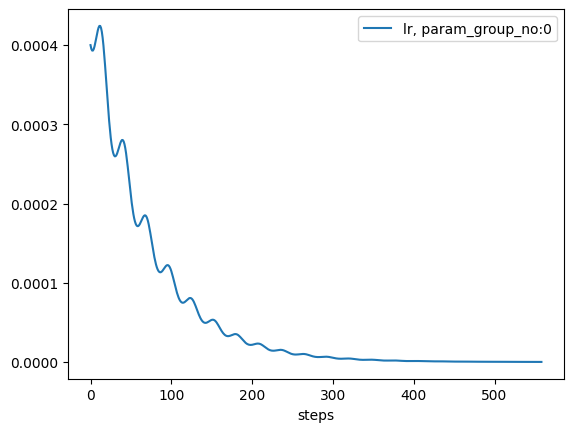

In [ ]:
reload(slt.models.utils)
wave = 10 ** slt.models.utils.downwards_wave(20, 28, np.log10(4e-4), -7, 0.2)

slt.models.utils.plot_lr_scheduler(
    lr_scheduler_class=slt.models.utils.FullyLambdaLR,
    lr_lambda = lambda epoch,base_lr,last_lr:(
        # last_lr*1.1 if epoch<5 else max(last_lr/2, last_lr + (base_lr/100 if epoch %2==0 else -base_lr/25))
        # last_lr * (1.01 if epoch%2 == 0 else 0.8)
        # last_lr * 0.5
        # base_lr / (1+0.1*epoch)
        (wave[epoch])
    ),
    initial_lr=1e-3,
    n_steps=20*28-1
)
# wave

In [7]:
reload(transformer_language_model.train)

trainer = transformer_language_model.train.LM_Trainer(
    tlm,
    device = device,
    epochs = 2,
    start_epoch_number=0,
    learning_rate = 4e-4,
    # lr_lambda=lambda epoch, base_lr, last_lr: last_lr * (1.05 if epoch%2 == 0 else 0.8),
    lr_lambda=lambda step_num, base_lr, last_lr: 10 ** slt.models.utils.downwards_wave(20, 28, np.log10(base_lr), -7, 0.2)[step_num if step_num < 20*28 else -1],
    optimizer="adamw",
    seed = 0,
    lr_update_step_count=100,
    model_output_renderer = lambda model : ur.detokenize(BeamSampling(model,max_length=window_size,start_of_sequence_token="<",end_of_sequence_token=">").complete(["<"])[0]),
    epoch_unfreeze_map={1: ["token_embedding"]},
    class_weights=torch.load("models/ur-lm-class-weights.pt").to(device) ** 2,
    max_gradient_norm=None, # 1.0
)
try:
    history = trainer.run(
        train_batches=train_batches,
        validation_batches=val_batches,
        checkpoint_dir = "models",
        checkpoint_step_count=1000,
    )
    plt.plot(np.linspace(0,1, len(history["train_loss"])), history["train_loss"])
    plt.plot(np.linspace(0,1, len(history["validation_loss"])), history["validation_loss"])
    plt.ylabel("loss")
    plt.xlabel("steps")
    plt.show()
except KeyboardInterrupt:
    tlm.eval()
    print("\n\033[31;1;4mKeyboardInterrupt\033[0m")
# expected initial loss: -np.log(1/vocab_size) = 7.847762537473608

epoch: 0 | train loss: 4.6880 | batches: 111/10531 1.1% | ETA: 5.8 hr | LR: 0.00039493 | <ابیہپہلےآپ2985193255125651754894812999717اکتوبر51515427925سال2275134نومبر2175918نگی طیارےادرکدولتفضول خرچیچھیانوےساتتباہیتراسیبنیادنازیہچھیننااسےپشاورپہلاانسستارےبنیادیسینتالیسفنعزیرچلتیزتیزپچہترنیتنیبو۲بول چالپشاوری
KeyboardInterrupt


In [23]:
tlm.save(f"models/tlm_{tlm.n_parameters/1e6:.1f}M.pt", overwrite=True)

#### load & infer

In [18]:
reload(transformer_language_model)
tlm = transformer_language_model.TransformerLanguageModel.load("models/tlm_14.0M.pt").to(device)

In [19]:
tokens, prob = sampler.complete(["<"])
sentence = ur.detokenize(tokens)
sentence

'<ان تمام افراد کے پاس کیا ہے اور ان کے والد کا نام ای سی ایل میں شامل کیا جائے گا کیا گیا تھا اور اس کے نام پر جواب دیا گیا'

In [ ]:
# sentence Lengths
gens = [sampler.complete(["<"])[0] for _ in tqdm(range(1000), leave=False)]
gens = sorted(gens, key=lambda x: (len(x), len(str(x))))
lens = [len(g) for g in gens]
gens = [ur.detokenize(g) for g in gens]
_ =plt.hist(lens, bins=20)
print(np.mean(lens), np.std(lens))

In [ ]:
# top next
tok, prob = tlm.next_all(['اس', " "])
tok, prob = np.array(tok), np.array(prob)
i = utils.top_p_top_k_indexes(prob, top_k=10)

list(zip(i, tok[i], prob[i])), 1/vocab_size